# Instacart Market Basket Analysis Customer Segmentation and RFM Analysis

In [4]:
# Import Necessary Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlite3
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

In [5]:
# Make import for GPU access in Colab

import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
# Create dataframes for necessary csv files

aisles = pd.read_csv('/content/drive/MyDrive/archive/aisles.csv')
departments = pd.read_csv('/content/drive/MyDrive/archive/departments.csv')
orders = pd.read_csv('/content/drive/MyDrive/archive/orders.csv')
products = pd.read_csv('/content/drive/MyDrive/archive/products.csv')
order_products_prior = pd.read_csv('/content/drive/MyDrive/archive/order_products__prior.csv')
order_products_train = pd.read_csv('/content/drive/MyDrive/archive/order_products__train.csv')

Define functions below for using K Means Clustering.
Uses code from: https://github.com/optiflow/rfm-customer-segmentation

In [7]:
# Define a function to test KMeans at various k
# This function uses silhouette score to evaluate KMeans
def optimal_kmeans(dataset, start=2, end=11):
    '''
    Calculate the optimal number of kmeans
    
    INPUT:
        dataset : dataframe. Dataset for k-means to fit
        start : int. Starting range of kmeans to test
        end : int. Ending range of kmeans to test
    OUTPUT:
        Values and line plot of Silhouette Score.
    '''
    
    # Create empty lists to store values for plotting graphs
    n_clu = []
    km_ss = []

    # Create a for loop to find optimal n_clusters
    for n_clusters in range(start, end):

        # Create cluster labels
        kmeans = KMeans(n_clusters=n_clusters)
        labels = kmeans.fit_predict(dataset)

        # Calculate model performance
        silhouette_avg = round(silhouette_score(dataset, labels, 
                                                random_state=1), 3)

        # Append score to lists
        km_ss.append(silhouette_avg)
        n_clu.append(n_clusters)

        print("No. Clusters: {}, Silhouette Score: {}, Change from Previous Cluster: {}".format(
            n_clusters, 
            silhouette_avg, 
            (km_ss[n_clusters - start] - km_ss[n_clusters - start - 1]).round(3)))

        # Plot graph at the end of loop
        if n_clusters == end - 1:
            plt.figure(figsize=(4,4))

            plt.title('Silhouette Score Elbow for KMeans Clustering')
            plt.xlabel('k')
            plt.ylabel('silhouette score')
            sns.pointplot(x=n_clu, y=km_ss)
            plt.savefig('silhouette_score.png', format='png', dpi=300,
                        pad_inches=2.0)
            plt.tight_layout()
            plt.show()

In [8]:
# Define a function to calculate and plot specified # of clusters
def kmeans(df, clusters_number):
    '''
    Implement k-means clustering on dataset
    
    INPUT:
        dataset : dataframe. Dataset for k-means to fit.
        clusters_number : int. Number of clusters to form.
        end : int. Ending range of kmeans to test.
    OUTPUT:
        Cluster results and t-SNE visualisation of clusters.
    '''   
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(df)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = df.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], 
                    hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new, cluster_labels

In [9]:
# Set up SQL Database for Later Use

conn = sqlite3.connect('aisles_database.db')

## Customer Segmentation

In [10]:
# Look at the data on a single user to see how segmentation could be applied

user_3 = orders[orders.user_id == 3]
user_3

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
26,1374495,3,prior,1,1,14,NaN
27,444309,3,prior,2,3,19,9.0
28,3002854,3,prior,3,3,16,21.0
29,2037211,3,prior,4,2,18,20.0
30,2710558,3,prior,5,0,17,12.0
31,1972919,3,prior,6,0,16,7.0
32,1839752,3,prior,7,0,15,7.0
33,3225766,3,prior,8,0,17,7.0
34,3160850,3,prior,9,0,16,7.0
35,676467,3,prior,10,3,16,17.0


### Perform Feature Engineering on training set to Approximate RFM Analysis

In [26]:
# Prepare Order Products Train for SQL Query

order_products_train.to_sql('order_products_train', conn)

In [27]:
# Set up SQL Query to Calculate Number of Products per Order

total_products_train_query = '''
    SELECT order_id,
           COUNT(product_id) AS products_total
    FROM order_products_train
    GROUP BY 1;
    '''

In [28]:
# Transform back into dataframe and view 

total_products_train_df = pd.read_sql(total_products_train_query, conn)
total_products_train_df.head()

,order_id,products_total
0,1,8
1,36,8
2,38,9
3,96,7
4,98,49


In [29]:
# Set Index of Total Products Train Dataframe to order_id for joining with others

total_products_train_df.set_index('order_id', inplace=True)
total_products_train_df.head()

,products_total
order_id,
1,8
36,8
38,9
96,7
98,49


In [30]:
# Join Orders Dataframe to Total Products Train Dataframe

combined_train_userdata = orders.join(total_products_train_df, how='inner', on='order_id')
combined_train_userdata.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,products_total
10,1187899,1,train,11,4,8,14.0,11
25,1492625,2,train,15,1,11,30.0,31
49,2196797,5,train,5,0,11,6.0,9
74,525192,7,train,21,2,11,6.0,9
78,880375,8,train,4,1,14,10.0,18


In [31]:
# Check Number of Rows in Combined Dataframe

len(combined_train_userdata)

131209

In [32]:
# Calculate total number of orders for each customer. This will equate to Recency in the RFM Analysis.

total_orders_train = combined_train_userdata.groupby('user_id')['order_number'].max()
total_orders_train.head()

user_id
1    11
2    15
5     5
7    21
8     4
Name: order_number, dtype: int64

In [33]:
# Calculate average lag between orders for each customer. This will equate to Frequency in the RFM Analysis.

lag_mean_train = round(combined_train_userdata.groupby('user_id')['days_since_prior_order'].mean(), 0)
lag_mean_train.head()

user_id
1    14.0
2    30.0
5     6.0
7     6.0
8    10.0
Name: days_since_prior_order, dtype: float64

In [34]:
# Calculate average number of products ordered per customer. This will equate to Monetary in the RFM Analysis.

products_mean_train = round(combined_train_userdata.groupby('user_id')['products_total'].mean(), 0)
products_mean_train.head()

user_id
1    11
2    31
5     9
7     9
8    18
Name: products_total, dtype: int64

In [35]:
# Combine new features into dataframe for RFM Analysis and Customer Segmentation

rfm_features_train = pd.concat([total_orders_train, lag_mean_train, products_mean_train], axis=1)
rfm_features_train.columns = ['total_orders(Recency)', 'lag_mean(Frequency)', 'products_mean(Monetary)']
rfm_features_train.head()

,total_orders(Recency),lag_mean(Frequency),products_mean(Monetary)
user_id,,,
1,11,14.0,11
2,15,30.0,31
5,5,6.0,9
7,21,6.0,9
8,4,10.0,18


In [36]:
# Check for any missing values

rfm_features_train.isna().sum()

total_orders(Recency)      0
lag_mean(Frequency)        0
products_mean(Monetary)    0
dtype: int64

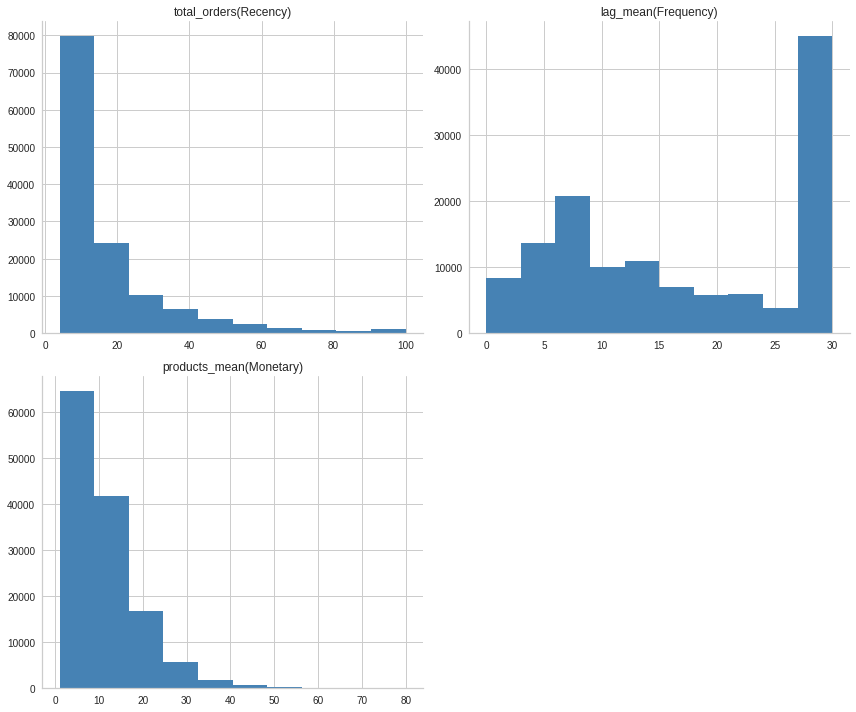

In [37]:
# Visualize distribution of each feature to check for non-normal distributions

rfm_features_train.hist(figsize = (12,10), color='steelblue')
plt.tight_layout()
sns.despine()
plt.savefig('rfm_train_initial_distribution.png', dpi=300, pad_inches=0.5)
plt.show()

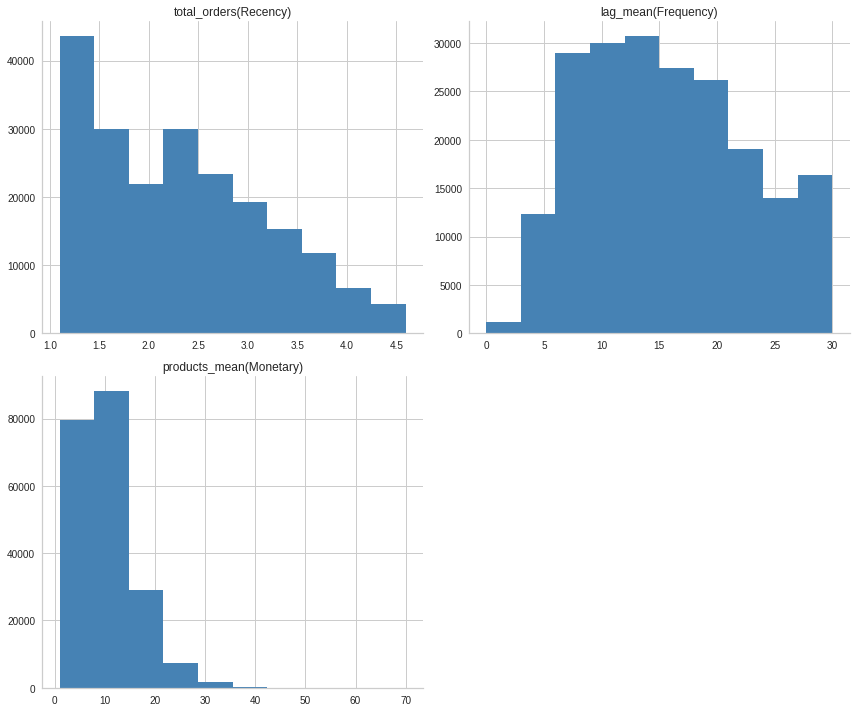

In [38]:
# Log transform features to create a normal distribution

rfm_features_train['total_orders(Recency)'] = np.log(rfm_features_train['total_orders(Recency)'])
rfm_features_train['products_mean(Monetary)'] = np.log(rfm_features_train['products_mean(Monetary)'])
rfm_features.hist(figsize = (12,10), color='steelblue')
plt.tight_layout()
sns.despine()
plt.savefig('rfm_train_distribution_with_logtransform.png', dpi=300, pad_inches=0.5)
plt.show()

In [39]:
# Standardize the features to reduce the effect of outliers on segmentation

scaler = StandardScaler()
rfm_features_train_scaled = scaler.fit_transform(rfm_features_train)

In [40]:
# Create Dataframe with standardized features and check summary stats

rfm_features_train_scaled = pd.DataFrame(rfm_features_train_scaled)
rfm_features_train_scaled.describe().apply(lambda s: s.apply('{0:.3f}'.format))

,0,1,2
count,131209.000,131209.000,131209.000
mean,0.000,0.000,0.000
std,1.000,1.000,1.000
min,-1.332,-1.597,-2.415
25%,-0.827,-0.941,-0.520
50%,-0.190,-0.192,0.172
75%,0.675,1.213,0.693
max,2.682,1.213,2.745


### Customer Segmentation Using K-Means on Training Data

No. Clusters: 2, Silhouette Score: 0.323, Change from Previous Cluster: 0.0
No. Clusters: 3, Silhouette Score: 0.308, Change from Previous Cluster: -0.015
No. Clusters: 4, Silhouette Score: 0.322, Change from Previous Cluster: 0.014
No. Clusters: 5, Silhouette Score: 0.314, Change from Previous Cluster: -0.008
No. Clusters: 6, Silhouette Score: 0.31, Change from Previous Cluster: -0.004
No. Clusters: 7, Silhouette Score: 0.294, Change from Previous Cluster: -0.016
No. Clusters: 8, Silhouette Score: 0.284, Change from Previous Cluster: -0.01
No. Clusters: 9, Silhouette Score: 0.276, Change from Previous Cluster: -0.008
No. Clusters: 10, Silhouette Score: 0.281, Change from Previous Cluster: 0.005


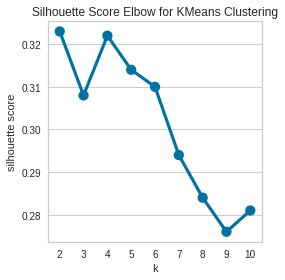

In [43]:
# Use Silhouette Score to identify optimal number of clusters

optimal_kmeans(rfm_features_train_scaled, 2, 11)

(               0         1         2  Cluster
 0      -0.070845 -0.285653  0.408773        0
 1       0.315956  1.212924  1.628929        1
 2      -1.054149 -1.034942  0.172453        0
 3       0.735578 -1.034942  0.172453        0
 4      -1.332436 -0.660298  0.988739        0
 ...          ...       ...       ...      ...
 131204  0.674731  1.212924  1.225059        1
 131205  0.902108 -1.034942  1.052411        0
 131206 -0.826771  1.212924  0.605505        1
 131207 -1.332436 -0.660298  1.052411        0
 131208  0.229913  1.212924  0.033745        1
 
 [131209 rows x 4 columns], array([0, 1, 0, ..., 1, 0, 1], dtype=int32))

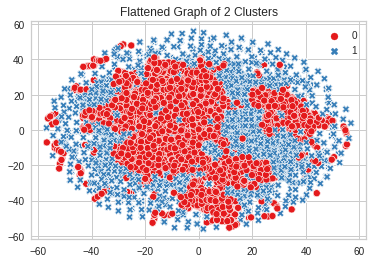

In [52]:
# Analysis points to 3 clusters being a clear "elbow" - test for 2, 3, and 4 clusters

kmeans(rfm_features_train_scaled, 2)

(               0         1         2  Cluster
 0      -0.070845 -0.285653  0.408773        1
 1       0.315956  1.212924  1.628929        0
 2      -1.054149 -1.034942  0.172453        1
 3       0.735578 -1.034942  0.172453        1
 4      -1.332436 -0.660298  0.988739        0
 ...          ...       ...       ...      ...
 131204  0.674731  1.212924  1.225059        0
 131205  0.902108 -1.034942  1.052411        1
 131206 -0.826771  1.212924  0.605505        0
 131207 -1.332436 -0.660298  1.052411        0
 131208  0.229913  1.212924  0.033745        0
 
 [131209 rows x 4 columns], array([1, 0, 1, ..., 0, 0, 0], dtype=int32))

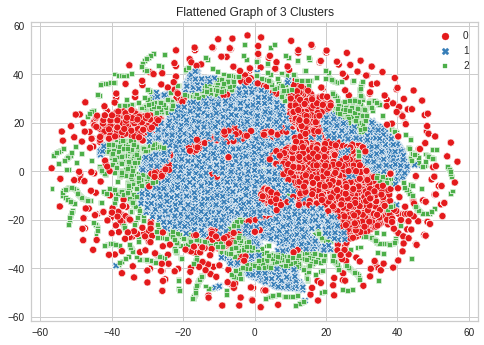

In [ ]:
# Visualize 3 clusters

kmeans(rfm_features_train_scaled, 3)

(               0         1         2  Cluster
 0      -0.070845 -0.285653  0.408773        1
 1       0.315956  1.212924  1.628929        0
 2      -1.054149 -1.034942  0.172453        1
 3       0.735578 -1.034942  0.172453        3
 4      -1.332436 -0.660298  0.988739        1
 ...          ...       ...       ...      ...
 131204  0.674731  1.212924  1.225059        0
 131205  0.902108 -1.034942  1.052411        3
 131206 -0.826771  1.212924  0.605505        0
 131207 -1.332436 -0.660298  1.052411        1
 131208  0.229913  1.212924  0.033745        0
 
 [131209 rows x 4 columns], array([1, 0, 1, ..., 0, 1, 0], dtype=int32))

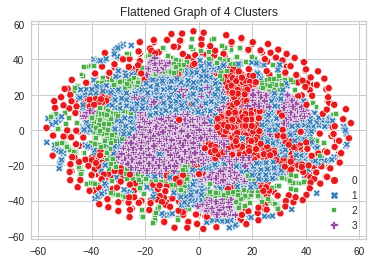

In [41]:
# Visualize 4 clusters

kmeans(rfm_features_train_scaled, 4)

(               0         1         2  Cluster
 0      -0.070845 -0.285653  0.408773        1
 1       0.315956  1.212924  1.628929        0
 2      -1.054149 -1.034942  0.172453        5
 3       0.735578 -1.034942  0.172453        1
 4      -1.332436 -0.660298  0.988739        5
 ...          ...       ...       ...      ...
 131204  0.674731  1.212924  1.225059        4
 131205  0.902108 -1.034942  1.052411        1
 131206 -0.826771  1.212924  0.605505        0
 131207 -1.332436 -0.660298  1.052411        5
 131208  0.229913  1.212924  0.033745        4
 
 [131209 rows x 4 columns], array([1, 0, 5, ..., 0, 5, 4], dtype=int32))

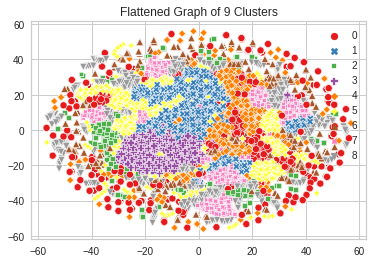

In [44]:
# Also test 9, as an experiment

kmeans(rfm_features_train_scaled, 9)

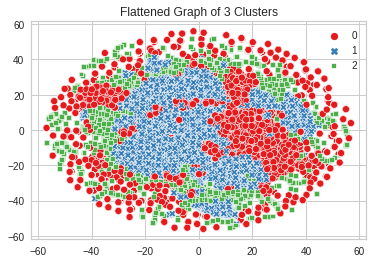

In [45]:
# Three clusters looks most promising. Create a snake plot to visualize and learn about each cluster

k3 = kmeans(rfm_features_train_scaled, 3)

In [48]:
# Convert clusters to DataFrame and create index and column names

cluster_three_train_df = pd.DataFrame(k3[0])
cluster_three_train_df.index = rfm_features_train.index
cluster_three_train_df.columns = ['Total Orders (Recency)', 'Lag Mean (Frequency)', 
                      'Products Mean (Monetary)', 'Cluster']
cluster_three_train_df.head()

,Total Orders (Recency),Lag Mean (Frequency),Products Mean (Monetary),Cluster
user_id,,,,
1,-0.070845,-0.285653,0.408773,1
2,0.315956,1.212924,1.628929,0
5,-1.054149,-1.034942,0.172453,1
7,0.735578,-1.034942,0.172453,1
8,-1.332436,-0.660298,0.988739,0


In [49]:
# Reshape data for snake plot

cluster_three_train_melt = pd.melt(cluster_three_train_df.reset_index(),
                       id_vars=['user_id', 'Cluster'],
                       value_vars=['Total Orders (Recency)', 
                                   'Lag Mean (Frequency)', 
                                   'Products Mean (Monetary)'],
                       var_name='Metric',
                       value_name='Value')

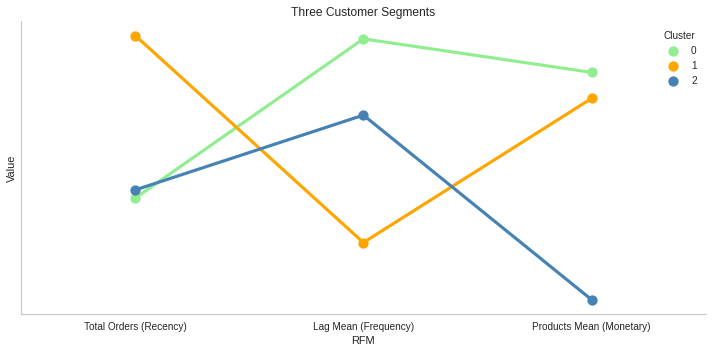

In [51]:
# Create snake plot

palette = ['lightgreen', 'orange', 'steelblue']
plt.figure(figsize=(10,5))
sns.pointplot(x='Metric', y='Value', data=cluster_three_train_melt, hue='Cluster', 
              palette=palette)
plt.xlabel('RFM')
plt.ylabel('Value')
plt.yticks([])
plt.title('Three Customer Segments')
sns.despine()
plt.tight_layout()
plt.savefig('snake_plot.png', dpi=300, pad_inches=2.0)
plt.show()

### Observations

1.   Customer Segment 0 - These customers score low for recency, do not order very often, but have a high value for monetary. Marketing recommendations could include incentives for more frequent orders and increasing the number of orders they make.
2.   Customer Segment 1 - These are ideal customers. They score high for recency, have a low lag between orders meaning they order frequently, and score high for monetary. Prioritize customer satisfaction and keeping these customers happy.
3.   Customer Segment 2 - These customers score low for recency, have a relatively high lag between orders meaning they don't order frequently, and they also score very low for monetary. By far, these are the least valuable customers for Instacart currently. Strategies could focus on targeted specials on the most popular products to entice these customers to order more frequently and become more valuable customers for Instacart.

